In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/huggingface/diffusers.git
%cd diffusers
%pip install .

Cloning into 'diffusers'...
remote: Enumerating objects: 64308, done.
remote: Counting objects: 100% (821/821), done.
remote: Compressing objects: 100% (445/445), done.
remote: Total 64308 (delta 526), reused 498 (delta 317), pack-reused 63487
Receiving objects: 100% (64308/64308), 47.96 MiB | 19.06 MiB/s, done.
Resolving deltas: 100% (47015/47015), done.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.30.0.dev0-py3-none-any.whl size=2209943 sha256=391da5cc76b109d3bbcd8a528c7403cb73e4fa2e0a1f2aa7bbfd5f102338eb95
  Stored in directory: /tmp/pip-ephem-wheel-cache-rii5e8az/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers


In [3]:
ckpt_path = '/content/drive/MyDrive/style_dreambooth.safetensors'

In [4]:
tmp_ckpt_dir = "/content/ckpt_dir/"
!mkdir -p $tmp_ckpt_dir

In [5]:
!python /content/diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py \
        --checkpoint_path $ckpt_path \
        --dump_path $tmp_ckpt_dir \
        --from_safetensors

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
2024-06-17 20:01:49.672993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 20:01:49.673042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 20:01:49.676994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 20:01:52.208947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find

In [6]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline,EulerDiscreteScheduler, DDIMScheduler

from matplotlib.pyplot import figure, imshow, axis

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [7]:
pipe = StableDiffusionPipeline.from_pretrained(tmp_ckpt_dir, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /content/ckpt_dir/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /content/ckpt_dir/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /content/ckpt_dir/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /content/ckpt_dir/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion 

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

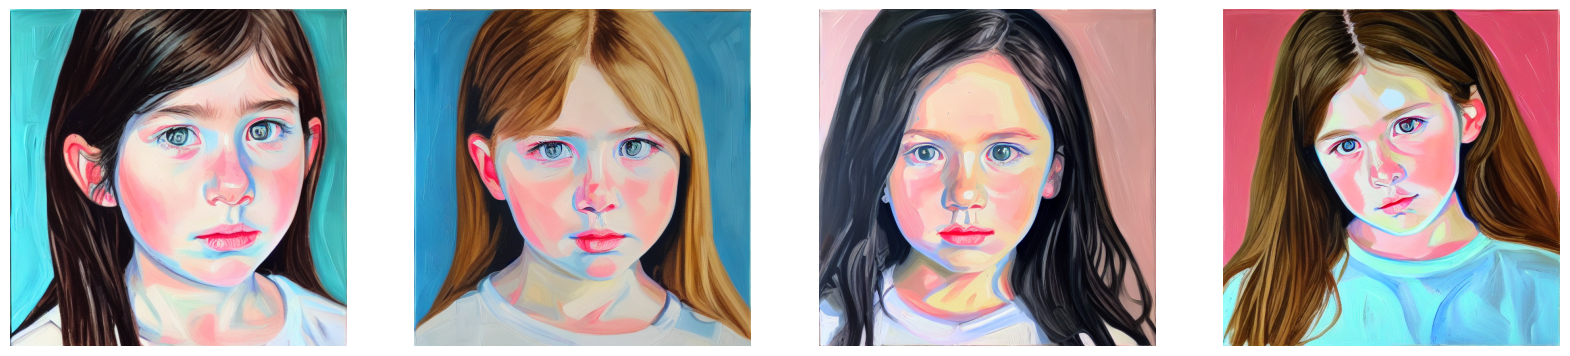

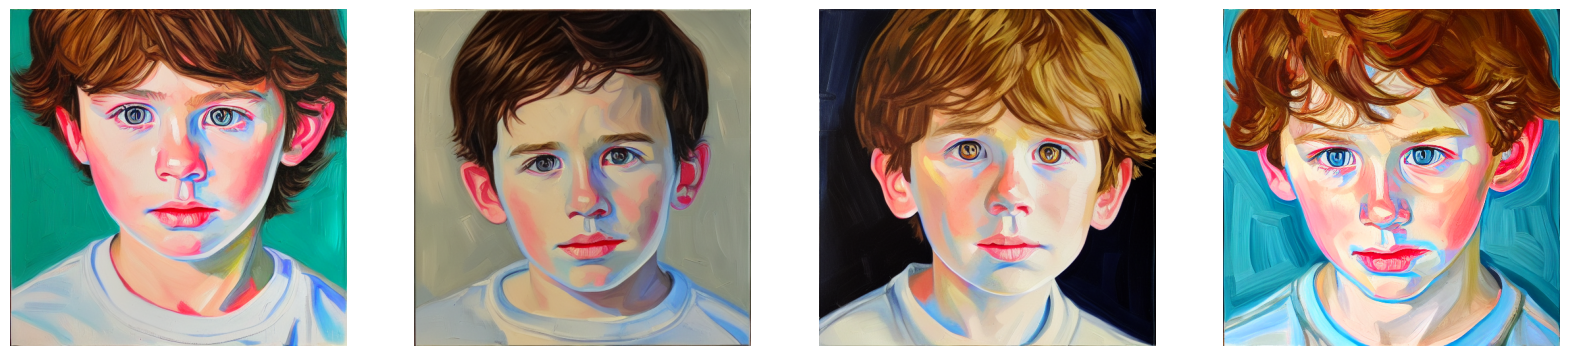

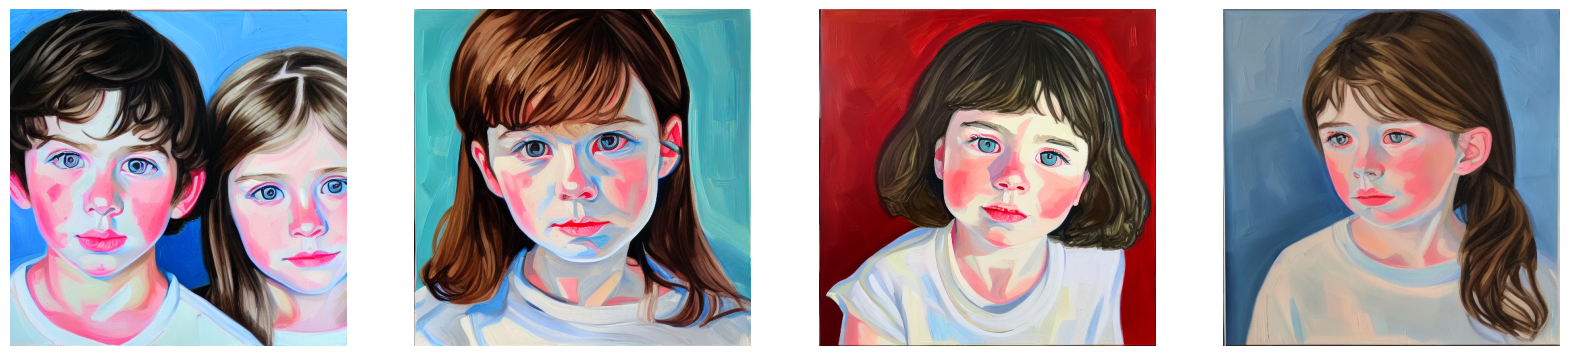

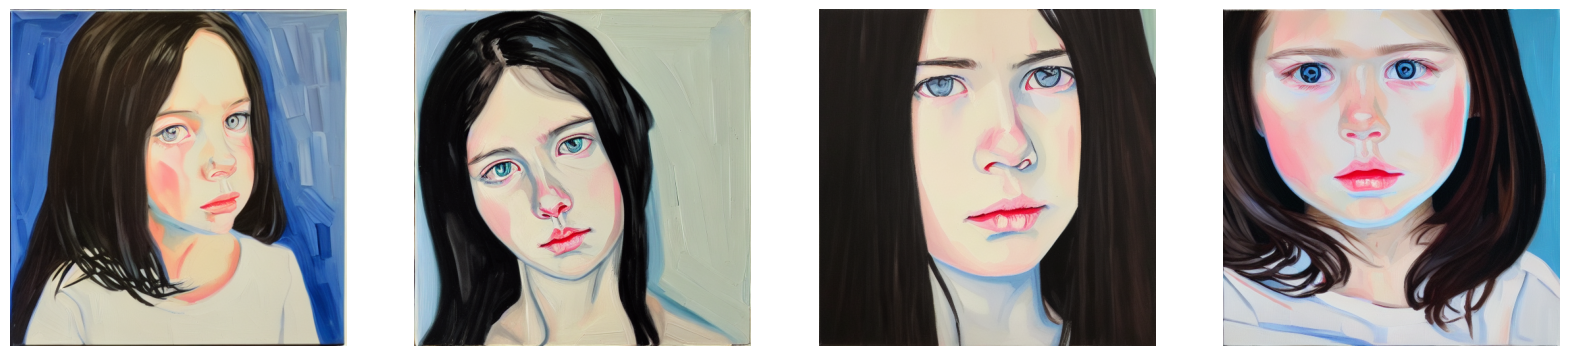

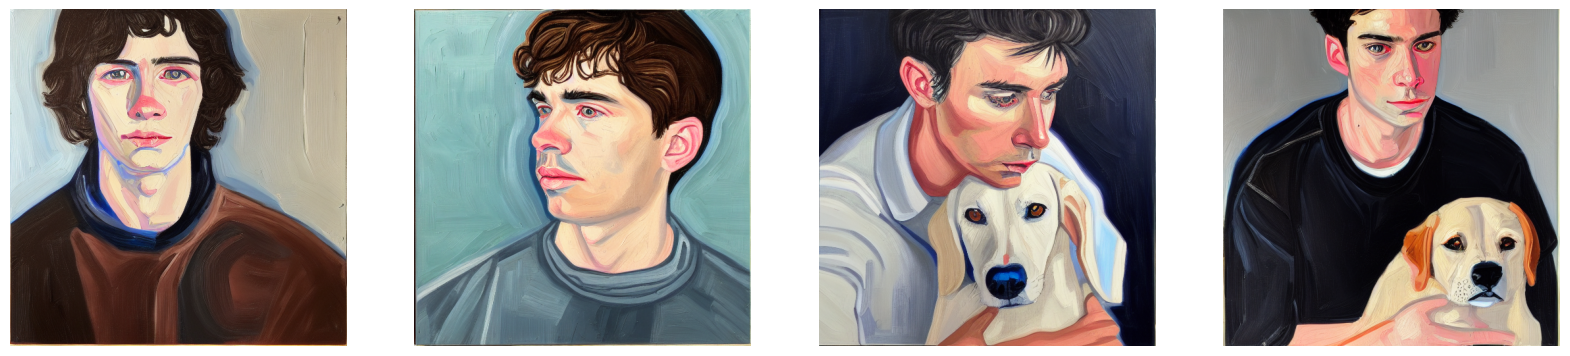

In [8]:
instance_prompt = "yltcaxe artstyle"

prompt_list = [f'{instance_prompt} a girl',
               f'{instance_prompt} a boy',
               f'{instance_prompt} a girl and a boy',
               f'{instance_prompt} a girl with dark hair',
               f'{instance_prompt} a man with a dog']

negative_prompt = ""
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

g_cuda = torch.Generator(device='cuda')
g_cuda.manual_seed(seed)

for prompt in prompt_list:
  with autocast("cuda"), torch.inference_mode():
      images = pipe(
          prompt,
          height=height,
          width=width,
          negative_prompt=negative_prompt,
          num_images_per_prompt=num_samples,
          num_inference_steps=num_inference_steps,
          guidance_scale=guidance_scale,
          generator=g_cuda
      ).images

      fig=figure(figsize=(5*num_samples,5*num_samples))
      for i in range(num_samples):
          a=fig.add_subplot(1, num_samples,i+1)
          imshow(images[i])
          axis('off')